In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
df = pd.read_csv('metals_and_alloys_dataset.csv')

train = df[df['test or train'] == 'train']
test = df[df['test or train'] == 'test']

In [3]:
proxies = ['uts_median', 'yield_median', 'comp_median', 'frac_median', 'hard_median', 'dens_median','bulk_median', 'shear_median', 'young_median']

X = df[proxies]
y = df['spall_median']

X_train = train[proxies]
X_test = test[proxies]
y_train = train['spall_median']
y_test = test['spall_median']


In [4]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
gpr_final = GaussianProcessRegressor(alpha=2,
                                     kernel=3.5**2 * RBF(length_scale=.43)  ,
                                     n_restarts_optimizer = 10,
                                     normalize_y=True,
                                     optimizer=None, 
                                     random_state=1)

In [6]:
model = gpr_final.fit(X_train_scaled, y_train);


In [7]:
y_gpr_test, y_gpr_test_std = model.predict(X_test_scaled, return_std=True)
y_gpr_train, y_gpr_train_std = model.predict(X_train_scaled, return_std=True)

In [8]:
train_r2 = r2_score(y_train, y_gpr_train)
train_r = stats.pearsonr(y_train, y_gpr_train)
train_rmse = root_mean_squared_error(y_train, y_gpr_train)

test_r2 = r2_score(y_test, y_gpr_test)
test_r = stats.pearsonr(y_test, y_gpr_test)
test_rmse = root_mean_squared_error(y_test, y_gpr_test)

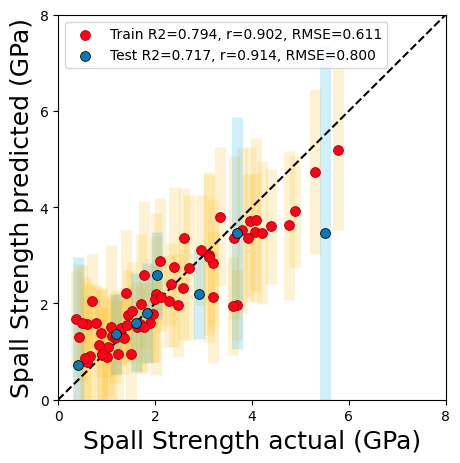

In [9]:
#Plot the model predictions

plt.rcParams['figure.figsize'] = [5,5]

x = np.linspace(0,15,15)
plt.ylim(0, 8)
plt.xlim(0, 8)
plt.yticks(np.arange(0, 10,2.0))

plt.errorbar(y_train,y_gpr_train, yerr=y_gpr_train_std, fmt='none', ecolor = '#fec129', alpha = 0.2, elinewidth=8, zorder=0)
plt.errorbar(y_test,y_gpr_test, yerr=y_gpr_test_std, fmt='none', ecolor = '#10afee', alpha = 0.2, elinewidth=8, zorder=0)

sns.scatterplot(x=y_train, y=y_gpr_train, 
                s=50,
                c="#ff0018",
                edgecolor="#9b000e",
                marker="o",
                label='Train R2=%.3f, r=%.3f, RMSE=%.3f' %(train_r2, train_r[0], train_rmse ),
                zorder=4) 

sns.scatterplot(x=y_test, y=y_gpr_test, 
                s=50,
                c="#0d78b3",
                edgecolor="k",
                marker="o",
                label='Test R2=%.3f, r=%.3f, RMSE=%.3f' %(test_r2, test_r[0], test_rmse ),
                zorder=5) 
                
plt.plot(x,x,'k', linestyle='--')
plt.xlabel('Spall Strength actual (GPa)', size=18)
plt.ylabel('Spall Strength predicted (GPa)', size=18)
plt.legend(loc='upper left')
plt.rc("font", family="Arial narrow")
plt.rc("xtick", labelsize=17)
plt.rc("ytick", labelsize=17)

plt.show()

In [10]:
## PRODUCTION MODEL

model = gpr_final.fit(X_scaled, y)
y_gpr, y_gpr_std = model.predict(X_scaled, return_std=True)


In [11]:
r2 = r2_score(y, y_gpr)
r = stats.pearsonr(y, y_gpr)
rmse = root_mean_squared_error(y, y_gpr)

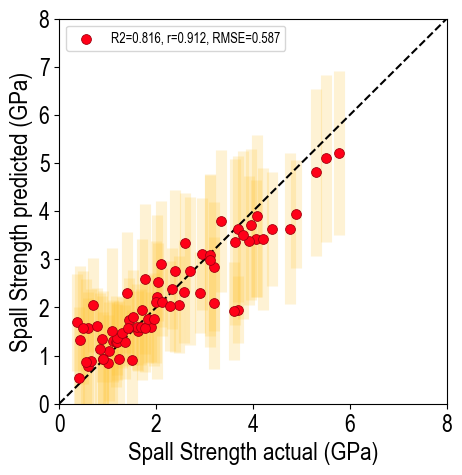

In [12]:
########################################################################################
#Plot the model predictions

#default for parity
x = np.linspace(0,8,len(y_test)+len(y_train))

#setup jupyter inline parameters
plt.rcParams['figure.figsize'] = [5,5]


plt.errorbar(y,y_gpr, yerr=y_gpr_std, fmt='none', ecolor = '#fec129', alpha = 0.2, elinewidth=8, zorder=0)

sns.scatterplot(x=y, y=y_gpr, 
                s=50,
                c="#ff0018",
                edgecolor="#9b000e",
                marker="o",
                label='R2=%.3f, r=%.3f, RMSE=%.3f' %(r2, r[0], rmse ),
                zorder=4) 

                
plt.plot(x,x,'k', linestyle='--')
plt.xlabel('Spall Strength actual (GPa)', size=18)
plt.ylabel('Spall Strength predicted (GPa)', size=18)
plt.ylim(0,8)
plt.xlim(0,8)
plt.legend(loc='upper left')
plt.rc("font", family="Arial narrow")
plt.rc("xtick", labelsize=17)
plt.rc("ytick", labelsize=17)


#show the plot
plt.show()

In [13]:
## SHAP analysis
explainer = shap.KernelExplainer(model.predict, X_scaled)
shap_values = explainer.shap_values(X_scaled)

  0%|          | 0/73 [00:00<?, ?it/s]

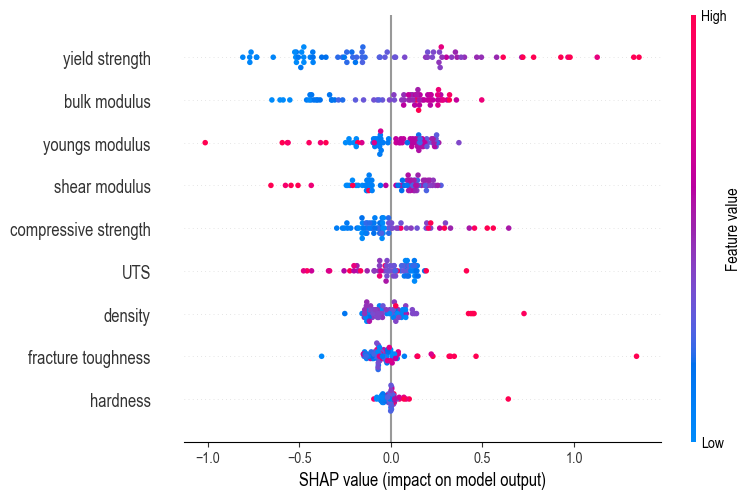

In [14]:
names = ['UTS', 'yield strength', 'compressive strength', 'fracture toughness', 'hardness', 'density','bulk modulus', 'shear modulus', 'youngs modulus']

shap.summary_plot(shap_values, X_scaled, feature_names=names) 


In [15]:
## VALIDATION
df_valid = pd.read_csv('alloys_for_validation.csv')

X_valid = df_valid[proxies]
y_valid = df_valid['spall_median']

X_valid_scaled = scaler.transform(X_valid)


df_valid

,name,class,spall_median,uts_median,yield_median,comp_median,bulk_median,shear_median,young_median,dens_median,hard_median,frac_median
0,93W,high,2.585,1241.0,920.0,1450,285,143,368,17.610,295,41.0
1,HfZrTiTa,high,3.240,1110.0,774.0,1300,110,25,70,9.358,372,62.0
2,Ti_5553,high,3.720,768.6,768.1,1138,82,43,109,4.638,413,33.9


In [16]:
y_gpr_valid, y_gpr_valid_std = model.predict(X_valid_scaled, return_std=True)


In [17]:
print('Material: ' + df_valid['name'].iloc[0] + ', experimental (GPa) = ' + str(round(y_valid[0],2)) + 
      ', prediction (GPa) = ' + str(round(y_gpr_valid[0],2))+ ', uncertainty (GPa) = ' + str(round(y_gpr_valid_std[0],2)))

print('Material: ' + df_valid['name'].iloc[1] + ', experimental (GPa) = ' + str(round(y_valid[1],2)) + 
      ', prediction (GPa) = ' + str(round(y_gpr_valid[1],2))+ ', uncertainty (GPa) = ' + str(round(y_gpr_valid_std[1],2)))

print('Material: ' + df_valid['name'].iloc[2] + ', experimental (GPa) = ' + str(round(y_valid[2],2)) + 
      ', prediction (GPa) = ' + str(round(y_gpr_valid[2],2))+ ', uncertainty (GPa) = ' + str(round(y_gpr_valid_std[2],2)))

Material: 93W, experimental (GPa) = 2.58, prediction (GPa) = 2.91, uncertainty (GPa) = 2.62
Material: HfZrTiTa, experimental (GPa) = 3.24, prediction (GPa) = 3.35, uncertainty (GPa) = 3.75
Material: Ti_5553, experimental (GPa) = 3.72, prediction (GPa) = 2.77, uncertainty (GPa) = 2.77
